In [2]:
import matplotlib.font_manager as font_manager
from descartes import PolygonPatch
from time import time
import alphashape
import seaborn as sns
from shapely.ops import cascaded_union, polygonize, unary_union
from shapely.geometry import LinearRing
from shapely.geometry import Point, MultiPoint
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from geopandas import GeoSeries
import numpy as np
import os
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from shapely import LineString
import pickle
from collections import Counter
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
# from contextily import add_basemap
from libpysal import weights
from descartes import PolygonPatch
from time import time
import alphashape
import seaborn as sns
from shapely.ops import cascaded_union, polygonize, unary_union

fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'

resultpath = 'results/'
network_polygon = '../../data/network/QGIS_Project/referentiel-comptages-edit.shp'

cycleways = gpd.read_file('../../data/cycleways_2000-2022.geojson')
plan_velo_2026 = gpd.read_file('../../data/plan-velo-2026.geojson')
cycleways_2010_2023 = cycleways[cycleways['date_de_livraison'] >= "2010-01-01"]
paris_districts = gpd.read_file('../../data/districts_paris.geojson')
polygon_all_districts = paris_districts.unary_union

def get_exterior_coords(df, start_point, end_point):
    filtered_gdf = df[(df["c_ar"] >= start_point) & (df["c_ar"] <= end_point)]

    # Check if there are any polygons matching the condition
    if not filtered_gdf.empty:
        # Apply unary_union to combine the selected polygons into a single polygon
        districts_polygon = unary_union(filtered_gdf["geometry"])
    else:
        # If no polygons match the condition, union_polygon will be None
        districts_polygon = None

    return districts_polygon.exterior.coords.xy

In [3]:
x_district_1_4, y_district_1_4  = get_exterior_coords(paris_districts, 1, 4)
x_district_5_7, y_district_5_7  = get_exterior_coords(paris_districts, 5, 7)

In [4]:
cycleways_red = cycleways[cycleways['typologie_simple'] == 'Pistes cyclables']

## Abstract


The goal of the noteook is to find the changes in bike kilometres for 2010 - 2023. Find it for both OSM and for the official cyclepaths created.

1. Official cycleways (dataframe: cycleways 2000 - 2022): Check changes 2010 - 2022 for red cyclepaths
2. Official cyclepaths: Check length of Plan Velo II (2026)
3. OSM: Check development of bike paths 2010 - 2022 -> ist vermutlich sehr fehlerbehaftet, daher das nicht direkt wahrnehmen.

In [6]:
cycleways_2010_2022 = cycleways_2010_2023[cycleways_2010_2023['date_de_livraison'] >= "2010-01-01"]
cycleways_red_2010_2022 = cycleways_2010_2022[cycleways_2010_2022['typologie_simple'] == 'Pistes cyclables']

In [20]:
def get_cycleways_for_district(x_coords, y_coords):
    district_polygon = Polygon(zip(x_coords, y_coords))

    # Create a GeoDataFrame containing the district polygon
    district_gdf = gpd.GeoDataFrame(geometry=[district_polygon], crs=cycleways_2010_2022.crs)

    # Use the GeoDataFrame's cx attribute to spatially filter cycleways_2010_2022
    return gpd.overlay(cycleways_2010_2022, district_gdf, how='intersection')

cycleways_district_1_4 = get_cycleways_for_district(x_district_1_4, y_district_1_4)
cycleways_district_5_7 = get_cycleways_for_district(x_district_5_7, y_district_5_7)


In [26]:
cycleways_zone_1_red = cycleways_district_1_4[cycleways_district_1_4['typologie_simple'] == 'Pistes cyclables']
cycleways_zone_2_red = cycleways_district_5_7[cycleways_district_5_7['typologie_simple'] == 'Pistes cyclables']

In [27]:
print(cycleways_district_1_4['length'].sum()/1000)
print(cycleways_district_5_7['length'].sum()/1000)

print(cycleways_zone_1_red['length'].sum()/1000)
print(cycleways_zone_2_red['length'].sum()/1000)

70.75519974985
74.23379081269002
15.409845540680003
14.447534860810004


In [7]:
# Get length in section in km
length_all_cycleways = cycleways['longueur_du_troncon_en_km'].sum()
print(length_all_cycleways)

length_all_red_cycleways = cycleways_red['longueur_du_troncon_en_km'].sum()
print(length_all_red_cycleways)

total_length= cycleways_2010_2022['longueur_du_troncon_en_km'].sum()
print(total_length)

total_length_red = cycleways_red_2010_2022['longueur_du_troncon_en_km'].sum()
print(total_length_red)

1083.09204407628
333.99113325182
660.84051164212
163.57121719795998


In [8]:
plan_velo_2026['length_in_km'] = plan_velo_2026['geometry'].length*100

length_plan_velo = plan_velo_2026['length_in_km'].sum()
print(length_plan_velo)

446.9888315379619


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_1272/3283003115.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plan_velo_2026['length_in_km'] = plan_velo_2026['geometry'].length*100


In [9]:
plan_velo_2026_existant = plan_velo_2026[plan_velo_2026['statut'] == "existant"]
plan_velo_2026_arealise = plan_velo_2026[plan_velo_2026['statut'] == "à réaliser"]

print(len(plan_velo_2026_existant))
print(len(plan_velo_2026_arealise))
print(len(plan_velo_2026))

140
183
323


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_1272/4185201032.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):


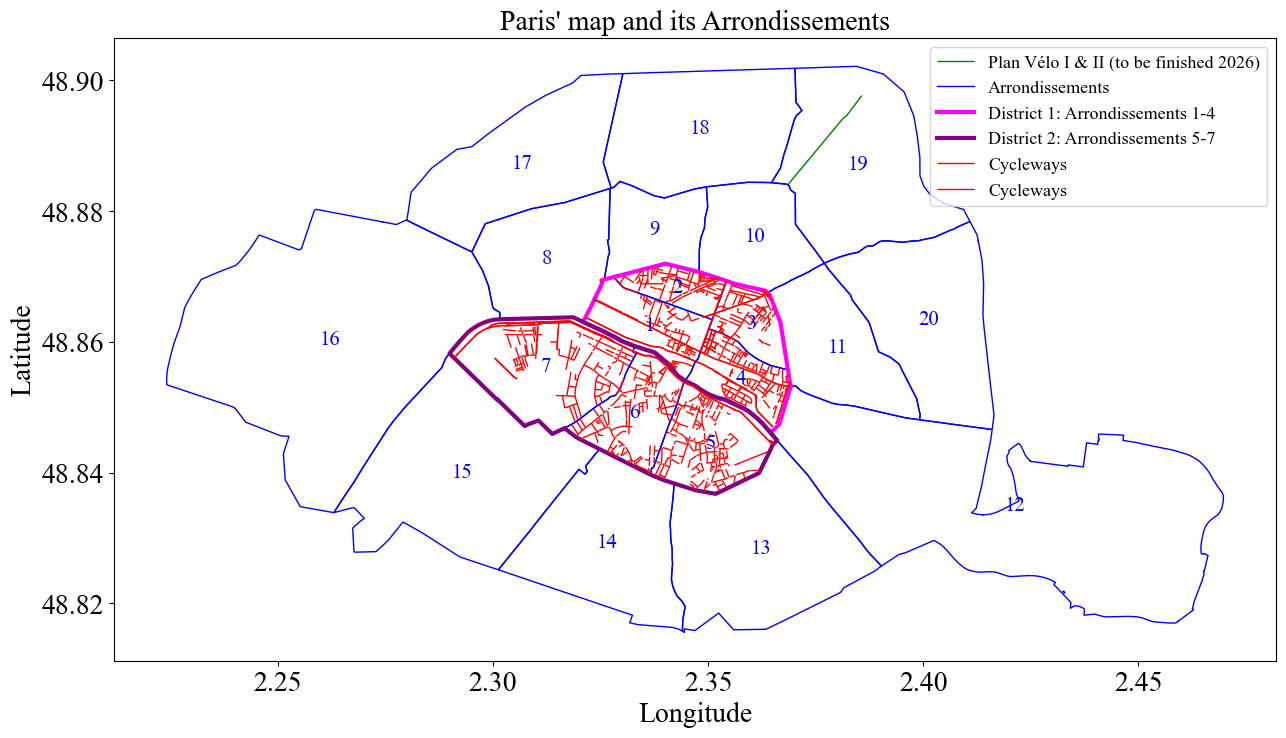

In [29]:
# plot the shapefile, and label the districts with the value in the column "l_ar"
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Paris\' map and its Arrondissements', font = font, fontsize = fontsize)

# df_osm_bike.plot(ax = ax, color = "grey", linewidth = 0.2, label = 'Network')

# paris_districts.plot(column='c_ar', ax=ax, legend=False, alpha = 0.1, edgecolor='black', linewidth = 5)
# df_osm.plot(ax = ax, color = "grey", linewidth = 0.2, label = "Road network")
# ax.plot(x_coords, y_coords, color='grey', linewidth=3, label='Study area')
# plan_velo_2026.plot(ax = ax, color = "green", linewidth = 1, label = "Plan Vélo I & II (to be finished 2026)")

first_row = plan_velo_2026.head(1)

# Plot the first row
first_row.plot(ax=ax, color = "green", linewidth = 1, label = "Plan Vélo I & II (to be finished 2026)")

# cycleways_red.plot(ax = ax, color = "red", linewidth = 1, label = "Cycleways")

for idx, row in paris_districts.iterrows():
    # Plot each polygon
    x, y = row['geometry'].exterior.xy
    # plt.plot(x, y, color = "blue", linewidth = 1)
    if idx == 0:
        plt.plot(x, y, color = "blue", linewidth = 1, label = 'Arrondissements')
    else: 
        plt.plot(x, y, color = "blue", linewidth = 1)

plt.plot(x_district_1_4, y_district_1_4, color = 'magenta', linewidth = 3, label = 'District 1: Arrondissements 1-4')
plt.plot(x_district_5_7, y_district_5_7, color = 'purple', linewidth = 3, label = 'District 2: Arrondissements 5-7')
cycleways_district_5_7.plot(ax = ax, color = "red", linewidth = 1, label = "Cycleways")
cycleways_district_1_4.plot(ax = ax, color = "red", linewidth = 1, label = "Cycleways")

for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):
    ax.text(x, y, label, color = 'blue', fontsize=15, font = font, ha='center', va='center') 
plt.xticks(font = font, fontsize = fontsize)
plt.yticks(font = font, fontsize = fontsize)
plt.xlabel("Longitude", font = font, fontsize = fontsize)
plt.ylabel("Latitude", font = font, fontsize = fontsize)
font_legend = font_manager.FontProperties(family=font, style='normal', size=13)
plt.legend(loc='upper right', prop = font_legend)